In [12]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import pyhht
from statsmodels.tsa.ar_model import AutoReg
from scipy.signal import lfilter
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data

In [16]:
def Load_data(start, stop):

    #healthy person
    record_healthy = wfdb.rdrecord('emg_healthy', channels=[0])
    #signal flattening
    emg_signal_healthy = record_healthy.p_signal.flatten()
    #reducing the signal range
    emg_signal_healthy_range = emg_signal_healthy[start : stop]

    #person with myopathies
    record_myopathy = wfdb.rdrecord('emg_myopathy', channels=[0])
    emg_signal_myopathy = record_myopathy.p_signal.flatten()
    emg_signal_myopathy_range = emg_signal_myopathy[start : stop]

    #suffering from neuropathy
    record_neuropathy = wfdb.rdrecord('emg_neuropathy', channels = [0])
    emg_signal_neuropathy = record_neuropathy.p_signal.flatten()
    emg_signal_neuropathy_range = emg_signal_neuropathy[start : stop]

    return emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, start

# Visualization of loaded signals

In [17]:
def EMG_plot_noise(x_size, y_size, emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range,fs, start):#Zaszumiony sygnał

    offset = start/fs
    time = np.arange(len(emg_signal_healthy_range)) / fs + offset
    plt.figure(figsize=(x_size, y_size))

    #Subplot for a healthy person
    plt.subplot(311)
    plt.plot(time, emg_signal_healthy_range, label='Noisy EMG signal of a healthy person')
    plt.title('EMG signal before denoising')
    plt.ylabel('Amplitude [mV]')
    plt.legend()

    #Subplot for a person with myopathy
    plt.subplot(312)
    plt.plot(time, emg_signal_myopathy_range, label='Noisy EMG signal of a person with myopathy')
    plt.ylabel('Amplitude [mV]')
    plt.legend()

    #Subplot for a person with neuropathy
    plt.subplot(313)
    plt.plot(time, emg_signal_neuropathy_range, label='Noisy EMG signal of a person with neuropathy')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [mV]')
    plt.legend()

# EMD denoising function

In [18]:
#Empirical Mode Decomposition denoising
def EMD(emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range):#Empirical mode decomposition

    decomposer_healthy = pyhht.EMD(emg_signal_healthy_range) #An object is created, which will be used further for decomposition into IMFs
    imfs_healthy = decomposer_healthy.decompose() #Decomposition of the EMG signal into its IMF harmonic components.
    noise_window_healthy = emg_signal_healthy_range[0:500] #Selection of samples in the signal interval [a,b] representing the noise
    thresholds_healthy = np.std(noise_window_healthy)
    imfs_healthy_filtered = [pywt.threshold(c, thresholds_healthy) for c in imfs_healthy] #Thresholding
    emg_signal_healthy_denoised_EMD = np.sum(imfs_healthy_filtered, axis=0) #Reconstruction of the denoised signal by summing the denoised IMF

    decomposer_myopathy = pyhht.EMD(emg_signal_myopathy_range)
    noise_window_myopathy = emg_signal_myopathy_range[2000:3000]
    thresholds_myopathy = np.std(noise_window_myopathy)
    imfs_myopathy = decomposer_myopathy.decompose()
    imfs_myopathy_filtered = [pywt.threshold(c, thresholds_myopathy) for c in imfs_myopathy]
    emg_signal_myopathy_denoised_EMD = np.sum(imfs_myopathy_filtered, axis=0)

    decomposer_neuropathy = pyhht.EMD(emg_signal_neuropathy_range)
    imfs_neuropathy = decomposer_neuropathy.decompose()
    noise_window_neuropathy = emg_signal_neuropathy_range[0:1000]
    thresholds_neuropathy = np.std(noise_window_neuropathy)
    imfs_neuropathy_filtered = [pywt.threshold(c, thresholds_neuropathy) for c in imfs_neuropathy]
    emg_signal_neuropathy_denoised_EMD = np.sum(imfs_neuropathy_filtered, axis=0)

    return emg_signal_healthy_denoised_EMD, emg_signal_myopathy_denoised_EMD, emg_signal_neuropathy_denoised_EMD

def EMG_plot_comparision_EMD(x_size, y_size, emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, emg_signal_healthy_denoised_EMD, emg_signal_myopathy_denoised_EMD, emg_signal_neuropathy_denoised_EMD, fs, start):#Porównanie zaszumionego sygnału z odszumionym EMD

    offset = start/fs
    time = np.arange(len(emg_signal_healthy_range)) / fs + offset

    plt.figure(figsize=(x_size, y_size))

    #Subplot for a healthy person
    plt.subplot(311)
    plt.plot(time, emg_signal_healthy_range, label='Noisy EMG signal of a healthy person')
    plt.plot(time, emg_signal_healthy_denoised_EMD, label='Denoised EMG signal of a healthy person')
    plt.title('EMG signal after EMD denoising')
    plt.ylabel('Amplitude [mV]')
    plt.legend()

    #Subplot for a person with myopathy
    plt.subplot(312)
    plt.plot(time, emg_signal_myopathy_range, label='Noisy EMG signal of a person with myopathy')
    plt.plot(time, emg_signal_myopathy_denoised_EMD, label='Denoised EMG signal of a person with myopathy')
    plt.ylabel('Amplitude [mV]')
    plt.legend()

    #Subplot for a person with neuropathy
    plt.subplot(313)
    plt.plot(time, emg_signal_neuropathy_range, label='Noisy EMG signal of a person with neuropathy')
    plt.plot(time, emg_signal_neuropathy_denoised_EMD, label='Denoised EMG signal of a person with neuropathy')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [mV]')
    plt.legend()
    plt.show()

# DWT denoising function

In [19]:
#Discrete wavelet transform denoising
def DWT(emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, wavelet, level, value, mode):

    coefficients_healthy = pywt.wavedec(emg_signal_healthy_range, wavelet, level = level)#Wavelet decomposition
    coefficients_healthy[1:] = (pywt.threshold(i, value = value, mode = mode) for i in coefficients_healthy[1:])#Thresholding in soft mode
    emg_signal_healthy_denoised_DWT = pywt.waverec(coefficients_healthy, wavelet) #Inverse wavelet transform using reduced wavelets

    #Wavelet transform denoising for a person suffering from myopathy
    coefficients_myopathy = pywt.wavedec(emg_signal_myopathy_range, wavelet, level = level)
    coefficients_myopathy[1:] = (pywt.threshold(i, value = value, mode = mode) for i in coefficients_myopathy[1:])
    emg_signal_myopathy_denoised_DWT = pywt.waverec(coefficients_myopathy, wavelet)

    #Wavelet transform denoising for a person suffering from neuropathy
    coefficients_neuropathy = pywt.wavedec(emg_signal_neuropathy_range, wavelet, level = level)
    coefficients_neuropathy[1:] = (pywt.threshold(i, value = value, mode = mode) for i in coefficients_neuropathy[1:])
    emg_signal_neuropathy_denoised_DWT = pywt.waverec(coefficients_neuropathy, wavelet)

    return emg_signal_healthy_denoised_DWT, emg_signal_myopathy_denoised_DWT, emg_signal_neuropathy_denoised_DWT

def EMG_plot_comparision_DWT(x_size, y_size, emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, emg_signal_healthy_denoised_DWT, emg_signal_myopathy_denoised_DWT, emg_signal_neuropathy_denoised_DWT, fs, start):#Porównanie zaszumionego sygnału z odszumionym DWT
    offset = start/fs
    time = np.arange(len(emg_signal_healthy_range)) / fs + offset

    plt.figure(figsize=(x_size, y_size))

    #Subplot for a healthy person
    plt.subplot(311)
    plt.plot(time, emg_signal_healthy_range, label='Noisy EMG signal of a healthy person')
    plt.plot(time, emg_signal_healthy_denoised_DWT, label='Denoised EMG signal of a healthy person')
    plt.title('EMG signal after DWT denoising')
    plt.ylabel('Amplitude [mV]')
    plt.legend()

    #Subplot for a person with myopathy
    plt.subplot(312)
    plt.plot(time, emg_signal_myopathy_range, label='Noisy EMG signal of a person with myopathy')
    plt.plot(time, emg_signal_myopathy_denoised_DWT, label='Denoised EMG signal of a person with myopathy')
    plt.ylabel('Amplitude [mV]')
    plt.legend()

    #Subplot for a person with neuropathy
    plt.subplot(313)
    plt.plot(time, emg_signal_neuropathy_range, label='Noisy EMG signal of a person with neuropathy')
    plt.plot(time, emg_signal_neuropathy_denoised_DWT, label='Denoised EMG signal of a person with neuropathy')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [mV]')
    plt.legend()
    plt.show()

# AR denoising function

In [20]:
#Autoregressive AR model
def AR(emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, order):

    #Denoising using an autoregressive model for a healthy person
    model_healthy = AutoReg(emg_signal_healthy_range, lags=order,trend = 'ct')#Signal decomposition into coefficients with a specific order
    model_fit_healthy = model_healthy.fit()#Matching the signal to the coefficients
    coefficients_healthy = model_fit_healthy.params#Defining the parameters of the model
    emg_signal_healthy_denoised_AR = np.convolve(emg_signal_healthy_range, coefficients_healthy)#Convolution of both signals
    emg_signal_healthy_denoised_AR = emg_signal_healthy_denoised_AR[:len(emg_signal_healthy_range)]

    #Denoising using an autoregressive model for a person with myopathy
    model_myopathy = AutoReg(emg_signal_myopathy_range, lags=order)
    model_fit_myopathy = model_myopathy.fit()
    coefficients_myopathy = model_fit_myopathy.params
    emg_signal_myopathy_denoised_AR = np.convolve(emg_signal_myopathy_range, coefficients_myopathy)
    emg_signal_myopathy_denoised_AR = emg_signal_myopathy_denoised_AR[:len(emg_signal_myopathy_range)]

    #Denoising using an autoregressive model for a person with neuropathy
    model_neuropathy = AutoReg(emg_signal_neuropathy_range, lags=order)
    model_fit_neuropathy = model_neuropathy.fit()
    coefficients_neuropathy = model_fit_neuropathy.params
    emg_signal_neuropathy_denoised_AR = np.convolve(emg_signal_neuropathy_range, coefficients_neuropathy)
    emg_signal_neuropathy_denoised_AR = emg_signal_neuropathy_denoised_AR[:len(emg_signal_neuropathy_range)]

    return emg_signal_healthy_denoised_AR, emg_signal_myopathy_denoised_AR, emg_signal_neuropathy_denoised_AR

def EMG_plot_comparision_AR(x_size, y_size, emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, emg_signal_healthy_denoised_AR, emg_signal_myopathy_denoised_AR, emg_signal_neuropathy_denoised_AR, fs, start, delay):
    offset = start/fs
    time = np.arange(len(emg_signal_healthy_denoised_AR)) / fs + offset

    plt.figure(figsize=(x_size, y_size))

    #Subplot for a healthy person
    plt.subplot(311)
    plt.plot(time, emg_signal_healthy_range, label='Noisy EMG signal of a healthy person')
    plt.plot(time[start:len(emg_signal_healthy_range)], emg_signal_healthy_denoised_AR, label='Denoised EMG signal of a healthy person')
    plt.title('EMG signal after AR denoising')
    plt.ylabel('Amplitude [mV]')
    plt.legend()

    #Subplot for a person with myopathy
    plt.subplot(312)
    plt.plot(time, emg_signal_myopathy_range, label='Noisy EMG signal of a person with myopathy')
    plt.plot(time[start:len(emg_signal_myopathy_range)], emg_signal_myopathy_denoised_AR, label='Denoised EMG signal of a person with myopathy')
    plt.ylabel('Amplitude [mV]')
    plt.legend()

    #Subplot for a person with neuropathy
    plt.subplot(313)
    plt.plot(time, emg_signal_neuropathy_range, label='Noisy EMG signal of a person with neuropathy')
    plt.plot(time[start:len(emg_signal_neuropathy_range)], emg_signal_neuropathy_denoised_AR, label='Denoised EMG signal of a person with neuropathy')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [mV]')
    plt.legend()
    plt.show()

# Running individual sections of the program
### Load and visualize three EMG signals for a sample period of two seconds

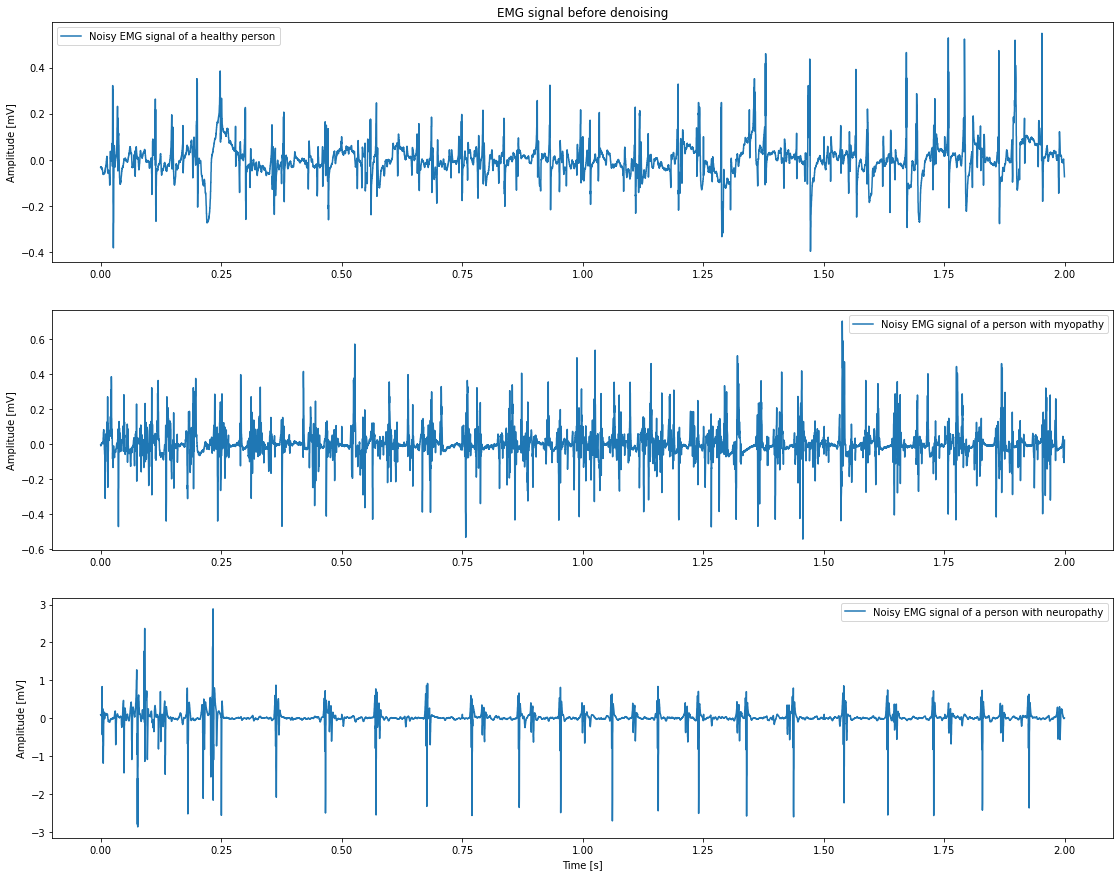

In [21]:
def main_plot():
    emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, start = Load_data(0, 8000)
    EMG_plot_noise(19, 15, emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range,4000, start)
    

main_plot()

### EMD function run and visualization

Mode 1, Iteration 600
3 minima > 0; 3283 maxima < 0.
Mode 1, Iteration 800
5 minima > 0; 3275 maxima < 0.
Mode 1, Iteration 1000
4 minima > 0; 3257 maxima < 0.
Mode 1, Iteration 1200
4 minima > 0; 3254 maxima < 0.
Mode 1, Iteration 1400
10 minima > 0; 3242 maxima < 0.
Mode 1, Iteration 1600
9 minima > 0; 3240 maxima < 0.
Mode 1, Iteration 1800
9 minima > 0; 3237 maxima < 0.


C:\Users\Patryk\anaconda3\lib\site-packages\pyhht\emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
1 minima > 0; 2921 maxima < 0.
Mode 1, Iteration 800
7 minima > 0; 2913 maxima < 0.
Mode 1, Iteration 1000
3 minima > 0; 2915 maxima < 0.
Mode 1, Iteration 1200
1 minima > 0; 2916 maxima < 0.
Mode 1, Iteration 1400
3 minima > 0; 2911 maxima < 0.
Mode 1, Iteration 1600
3 minima > 0; 2910 maxima < 0.
Mode 1, Iteration 1800
4 minima > 0; 2909 maxima < 0.
Mode 1, Iteration 600
4 minima > 0; 3314 maxima < 0.
Mode 1, Iteration 800
3 minima > 0; 3305 maxima < 0.
Mode 1, Iteration 1000
3 minima > 0; 3303 maxima < 0.
Mode 1, Iteration 1200
3 minima > 0; 3296 maxima < 0.
Mode 1, Iteration 1400
5 minima > 0; 3292 maxima < 0.
Mode 1, Iteration 1600
7 minima > 0; 3278 maxima < 0.
Mode 1, Iteration 1800
7 minima > 0; 3263 maxima < 0.


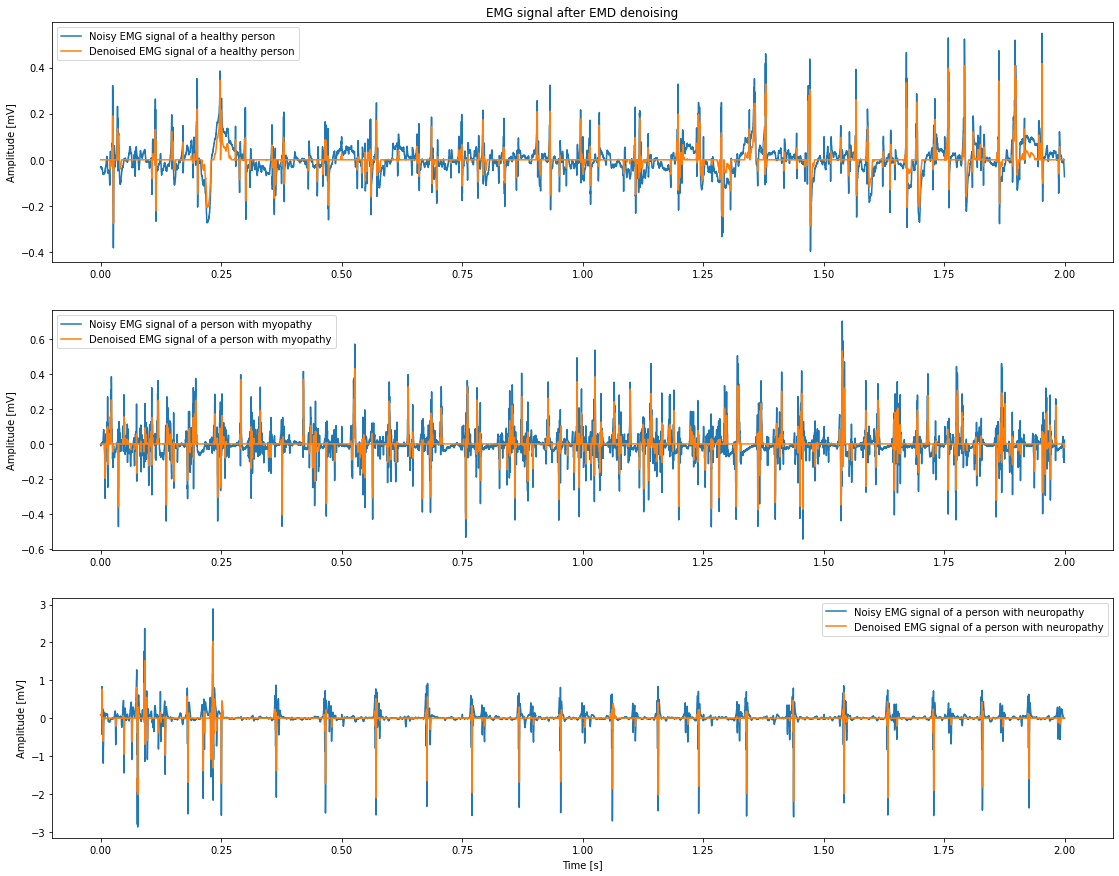

In [22]:
def main_EMD():
    emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, start = Load_data(0, 8000)
    emg_signal_healthy_denoised_EMD, emg_signal_myopathy_denoised_EMD, emg_signal_neuropathy_denoised_EMD = EMD(emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range)
    EMG_plot_comparision_EMD(19, 15, emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, emg_signal_healthy_denoised_EMD, emg_signal_myopathy_denoised_EMD, emg_signal_neuropathy_denoised_EMD, 4000, start)

main_EMD()

### DWT function run and visualization

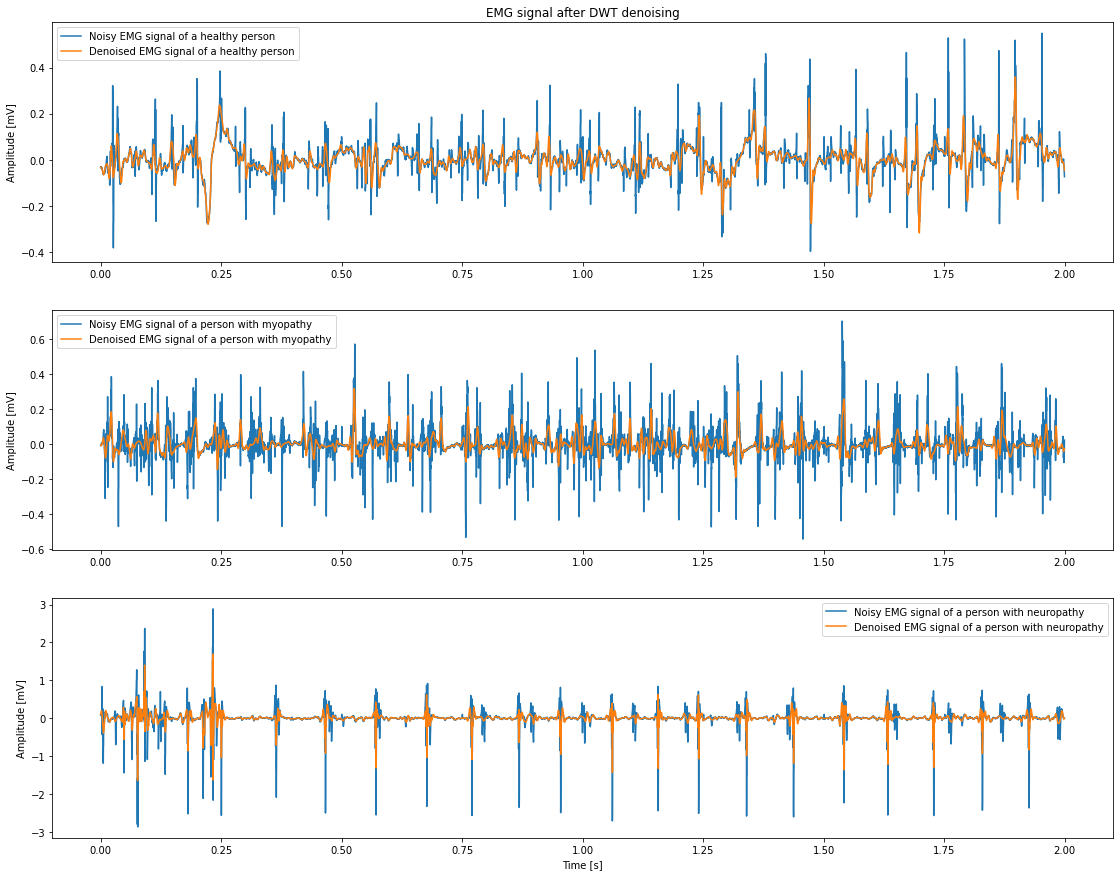

In [23]:
def main_DWT():
    emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, start = Load_data(0, 8000)
    emg_signal_healthy_denoised_DWT, emg_signal_myopathy_denoised_DWT, emg_signal_neuropathy_denoised_DWT = DWT(emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, 'db4', 4, 1, 'soft')
    EMG_plot_comparision_DWT(19, 15, emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, emg_signal_healthy_denoised_DWT, emg_signal_myopathy_denoised_DWT, emg_signal_neuropathy_denoised_DWT, 4000, start)
    

main_DWT()

### AR function run and visualization

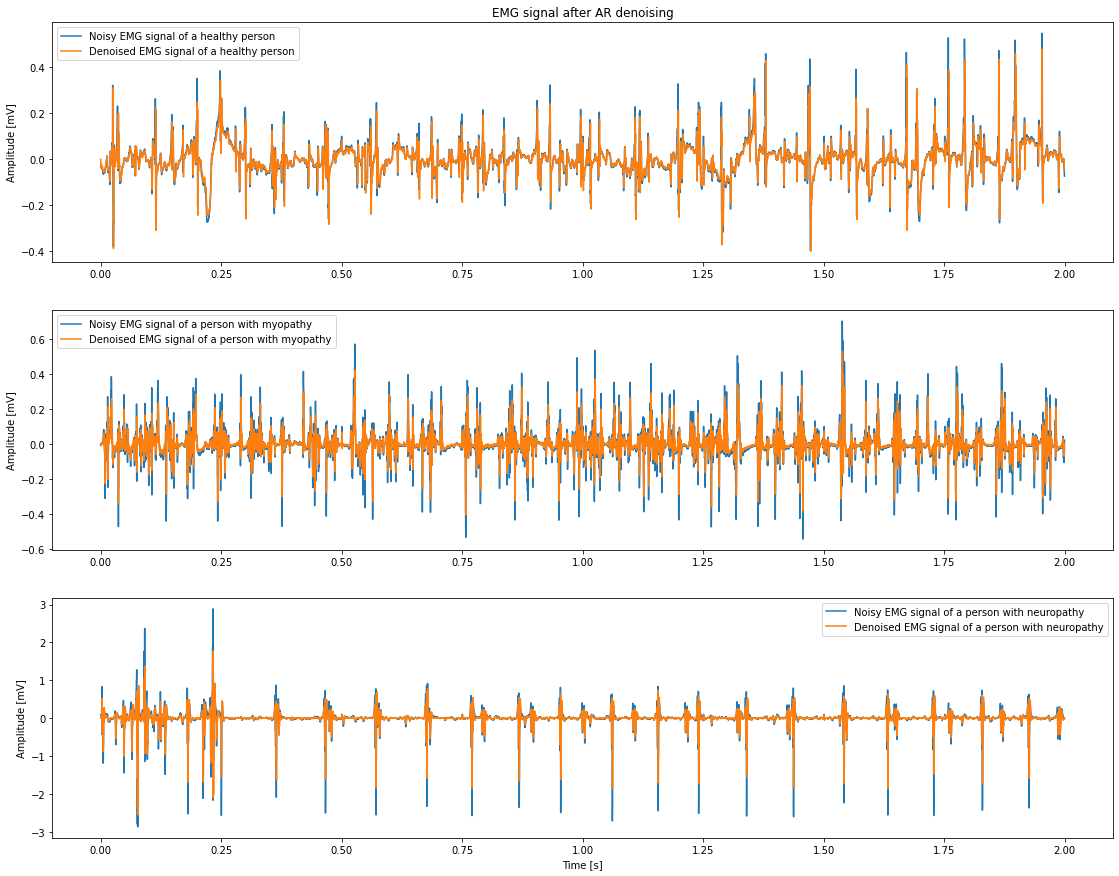

In [24]:
def main_AR():
    emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, start = Load_data(0, 8000)
    emg_signal_healthy_denoised_AR, emg_signal_myopathy_denoised_AR, emg_signal_neuropathy_denoised_AR = AR(emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, 15)
    EMG_plot_comparision_AR(19, 15, emg_signal_healthy_range, emg_signal_myopathy_range, emg_signal_neuropathy_range, emg_signal_healthy_denoised_AR, emg_signal_myopathy_denoised_AR, emg_signal_neuropathy_denoised_AR, 4000, start, 15)

main_AR()

# Quality tests of algorithms

Mode 9, Iteration 600
0 minima > 0; 142 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 12 maxima < 0.
EMD - MSE: 0.0007, MAE: 0.0176, SNR: 0.4566 [dB]
DWT - MSE: 0.0007, MAE: 0.0167, SNR: 0.7724 [dB]
AR - MSE: 0.0001, MAE: 0.0077, SNR: 8.9151 [dB]


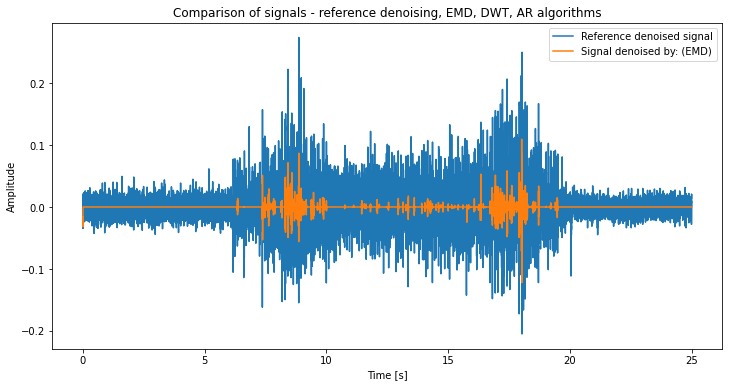

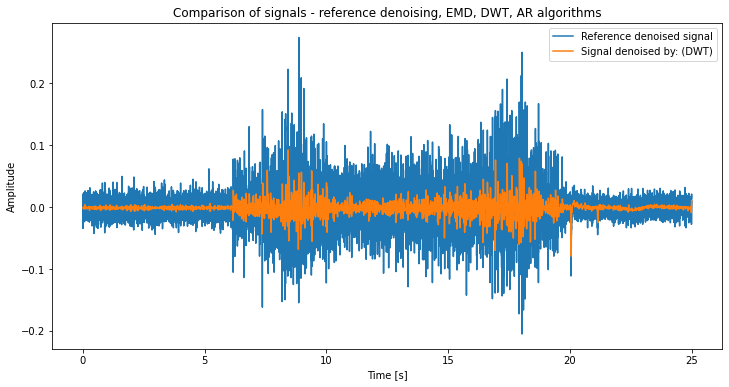

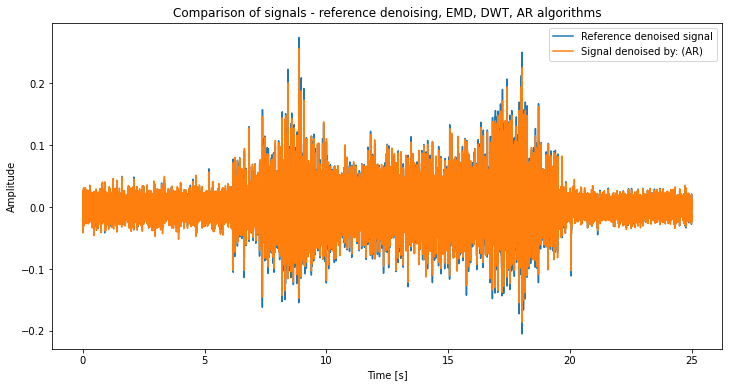

In [25]:
def Load_data_eval(start, stop):#Load signals from an alternative database

    record_raw = wfdb.rdrecord('ndof_raw_combination10_sample1', channels=[0])
    record_preproces = wfdb.rdrecord('ndof_preprocess_combination10_sample1', channels=[0])
    
    emg_raw = record_raw.p_signal.flatten()
    emg_range_raw = emg_raw[start : stop]
    
    emg_preproces = record_preproces.p_signal.flatten()
    emg_range_preproces = emg_raw[start : stop]

    return emg_range_raw, emg_range_preproces, start

def EMD_eval(emg_range_raw):#Use of the EMD algorithm for the new signal
    decomposer = pyhht.EMD(emg_range_raw)
    imfs = decomposer.decompose()
    noise_window = emg_range_raw[12000:20500]
    thresholds = np.std(noise_window)
    imfs_filtered = [pywt.threshold(c, thresholds) for c in imfs]
    emg_denoise_EMD = np.sum(imfs_filtered, axis=0)
    return emg_denoise_EMD

def DWT_eval(emg_range_raw, wavelet, level, value, mode):#Use of the DWT algorithm for the new signal
    coefficients = pywt.wavedec(emg_range_raw, wavelet, level=level)
    coefficients[1:] = (pywt.threshold(i, value=value, mode=mode) for i in coefficients[1:])
    emg_range_denoised_DWT = pywt.waverec(coefficients, wavelet)
    return emg_range_denoised_DWT

def AR_eval(emg_range_raw, order):#Use of AR algorithm for new signal
    model = AutoReg(emg_range_raw, lags=order)
    model_fit = model.fit()
    coefficients = model_fit.params
    emg_range_denoise_AR = np.convolve(emg_range_raw, coefficients)
    emg_range_denoise_AR = emg_range_denoise_AR[:len(emg_range_raw)]
    return emg_range_denoise_AR

def evaluate(noisy_signal, denoised_signal):#Calculation of qualitative metrics
    mse = mean_squared_error(noisy_signal, denoised_signal)
    mae = mean_absolute_error(noisy_signal, denoised_signal)
    snr = 10 * np.log10(np.mean(noisy_signal**2) / mse)
    return mse, mae, snr

def plot_comparison(original_signal, denoised_signal, method_name, fs):#Comparative visualization of noise reduction with reference noise reduction
    time = np.arange(len(original_signal)) / fs
    plt.figure(figsize=(12, 6))
    plt.plot(time, original_signal, label='Reference denoised signal')
    plt.plot(time, denoised_signal, label='Signal denoised by: ({})'.format(method_name))
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Comparison of signals - reference denoising, EMD, DWT, AR algorithms')
    plt.legend()
    plt.show()

def main_eval():#Running evaluation block
    emg_range_raw, emg_range_preproces, start = Load_data_eval(0, 51200)
    emg_denoise_EMD = EMD_eval(emg_range_raw)  
    emg_denoise_DWT = DWT_eval(emg_range_raw, wavelet='db4', level=5, value=0.5, mode='soft')
    emg_denoise_AR = AR_eval(emg_range_raw, order=20)
    
    mse_EMD, mae_EMD, snr_EMD = evaluate(emg_range_preproces, emg_denoise_EMD)
    mse_DWT, mae_DWT, snr_DWT = evaluate(emg_range_preproces, emg_denoise_DWT)
    mse_AR, mae_AR, snr_AR = evaluate(emg_range_preproces, emg_denoise_AR)

    print("EMD - MSE: {:.4f}, MAE: {:.4f}, SNR: {:.4f} [dB]".format(mse_EMD, mae_EMD, snr_EMD))
    print("DWT - MSE: {:.4f}, MAE: {:.4f}, SNR: {:.4f} [dB]".format(mse_DWT, mae_DWT, snr_DWT))
    print("AR - MSE: {:.4f}, MAE: {:.4f}, SNR: {:.4f} [dB]".format(mse_AR, mae_AR, snr_AR))
    
    plot_comparison(emg_range_preproces, emg_denoise_EMD, 'EMD', 2048)
    plot_comparison(emg_range_preproces, emg_denoise_DWT, 'DWT', 2048)
    plot_comparison(emg_range_preproces, emg_denoise_AR, 'AR', 2048)
    
main_eval()